# Выпускная квалификационная работа по курсу «Data Science»

---



Задание на ВКР:
1.	Обучить алгоритм машинного обучения, который будет определять значения:
•	Модуль упругости при растяжении, ГПа;
•	Прочность при растяжении, МПа.
2.	Написать нейронную сеть, которая будет рекомендовать:
•	Соотношение матрица-наполнитель.
3.	Написать приложение, которое будет выдавать прогноз, полученный в задании 1 или 2 (один или два прогноза, на выбор учащегося).
4.	Создать профиль на github.com.
5.	Сделать commit приложения на github.com.
6.	Сделать commit на веб-хостинг (по желанию учащегося).

Для решения необходимо:

1.Провести разведочный анализ предложенных данных. Нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Также для каждой колонки получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
2.Провести предобработку данных (удаление выбросов, нормализация и т.д.)
3.Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении.
4.Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.
5.Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз.
Оценить точность модели на тренировочном и тестовом датасете.
Создать репозиторий в GitHub / GitLab и разместить там код исследования.

In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

In [9]:
# Пути для гугл драйв
 #nb_path = '/content/drive/MyDrive/Colab Notebooks/'
 #data_path = '/content/drive/MyDrive/Colab Notebooks/data/'
 #models_path = '/content/drive/MyDrive/Colab Notebooks/models/'

## Подключение библиотек


In [10]:
# Импорт  библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics
from pathlib import Path
import pickle
import os
import tensorflow as tf
from tensorflow import keras

In [11]:
# Пути для локального запуска
models_path='/content/sample_data/models/'

In [12]:
#настройки
RANDOM_STATE = 42
pd.set_option('display.float_format', '{:.3f}'.format)


## Ввод данных

In [14]:
# чтение их файла (надо в ручную загрузить эти файлы /content... в )
X_bp = pd.read_csv('/content/sample_data/X_bp.csv',sep=';') # считать данные из файла X_bp
X_nup = pd.read_csv('/content/sample_data/X_nup.csv',sep=';') # счмиать данные из файла X_nup

In [15]:
X_bp.head(5)#просмотр заголовка и первых 5 строк

,Индекс,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0,0,1.857,2030.000,738.737,30.000,22.268,100.000,210.000,70.000,3000.000,220.000
1,1,1.857,2030.000,738.737,50.000,23.750,284.615,210.000,70.000,3000.000,220.000
2,2,1.857,2030.000,738.737,49.900,33.000,284.615,210.000,70.000,3000.000,220.000
3,3,1.857,2030.000,738.737,129.000,21.250,300.000,210.000,70.000,3000.000,220.000
4,4,2.771,2030.000,753.000,111.860,22.268,284.615,210.000,70.000,3000.000,220.000


In [16]:
X_nup.head(5)#просмотр заголовка и первых 5 строк

,Индекс,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,0,0,4.000,57.000
1,1,0,4.000,60.000
2,2,0,4.000,70.000
3,3,0,5.000,47.000
4,4,0,5.000,57.000


In [17]:
print(X_bp.shape,X_nup.shape)

(1023, 11) (1040, 4)


! Видно, количество строк в массивах разное

In [18]:
X = pd.merge(X_bp,X_nup,how = 'inner')# можно и так объединить
X.shape

(1023, 14)

После объединения число строк - по минимальной таблице

In [19]:
X.columns # названия столбцов

Index(['Индекс', 'Соотношение матрица-наполнитель', 'Плотность, кг/м3',
       'модуль упругости, ГПа', 'Количество отвердителя, м.%',
       'Содержание эпоксидных групп,%_2', 'Температура вспышки, С_2',
       'Поверхностная плотность, г/м2', 'Модуль упругости при растяжении, ГПа',
       'Прочность при растяжении, МПа', 'Потребление смолы, г/м2',
       'Угол нашивки, град', 'Шаг нашивки', 'Плотность нашивки'],
      dtype='object')

In [20]:
#оценим данные
X_info = pd.DataFrame({
    "DataType": X.dtypes,
    "MissingValues": X.isnull().sum(),
    "UniqueValues": X.nunique()
}).sort_values(by="MissingValues", ascending=False)

X_info['MissingValuesRatio'] = X_info['MissingValues'] / len(X)

X_info

,DataType,MissingValues,UniqueValues,MissingValuesRatio
Индекс,int64,0,1023,0.000
Соотношение матрица-наполнитель,float64,0,1014,0.000
"Плотность, кг/м3",float64,0,1013,0.000
"модуль упругости, ГПа",float64,0,1020,0.000
"Количество отвердителя, м.%",float64,0,1005,0.000
"Содержание эпоксидных групп,%_2",float64,0,1004,0.000
"Температура вспышки, С_2",float64,0,1003,0.000
"Поверхностная плотность, г/м2",float64,0,1004,0.000
"Модуль упругости при растяжении, ГПа",float64,0,1004,0.000
"Прочность при растяжении, МПа",float64,0,1004,0.000


! Все столбцы числовые, пропущенных  данных нет. Столбец **Угол нашивки, град** содержит 2 уникальных значения, остальные более 90%. Столбец **Индекс** не информативен и его следует удалить.

In [21]:
X.drop(['Индекс'], axis=1, inplace=True)# удалить столбец индекс
X.head(5)#просмотр заголовка и первых 5 строк

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857,2030.000,738.737,30.000,22.268,100.000,210.000,70.000,3000.000,220.000,0,4.000,57.000
1,1.857,2030.000,738.737,50.000,23.750,284.615,210.000,70.000,3000.000,220.000,0,4.000,60.000
2,1.857,2030.000,738.737,49.900,33.000,284.615,210.000,70.000,3000.000,220.000,0,4.000,70.000
3,1.857,2030.000,738.737,129.000,21.250,300.000,210.000,70.000,3000.000,220.000,0,5.000,47.000
4,2.771,2030.000,753.000,111.860,22.268,284.615,210.000,70.000,3000.000,220.000,0,5.000,57.000


## Разведочный анализ данных

Просмотр описательной статистики

In [22]:
X.describe().T # для наглядности транспонируем X

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.000,2.930,0.913,0.389,2.318,2.907,3.553,5.592
"Плотность, кг/м3",1023.000,1975.735,73.729,1731.765,1924.155,1977.622,2021.374,2207.773
"модуль упругости, ГПа",1023.000,739.923,330.232,2.437,500.047,739.664,961.813,1911.536
"Количество отвердителя, м.%",1023.000,110.571,28.296,17.740,92.443,110.565,129.730,198.953
"Содержание эпоксидных групп,%_2",1023.000,22.244,2.406,14.255,20.608,22.231,23.962,33.000
"Температура вспышки, С_2",1023.000,285.882,40.943,100.000,259.067,285.897,313.002,413.273
"Поверхностная плотность, г/м2",1023.000,482.732,281.315,0.604,266.817,451.864,693.225,1399.542
"Модуль упругости при растяжении, ГПа",1023.000,73.329,3.119,64.054,71.245,73.269,75.357,82.682
"Прочность при растяжении, МПа",1023.000,2466.923,485.628,1036.857,2135.850,2459.525,2767.193,3848.437
"Потребление смолы, г/м2",1023.000,218.423,59.736,33.803,179.628,219.199,257.482,414.591


! Все значения не отрицательны. Средние значения имееют значительный разброс.Требуется анализ данных на выбросы и нормализация.

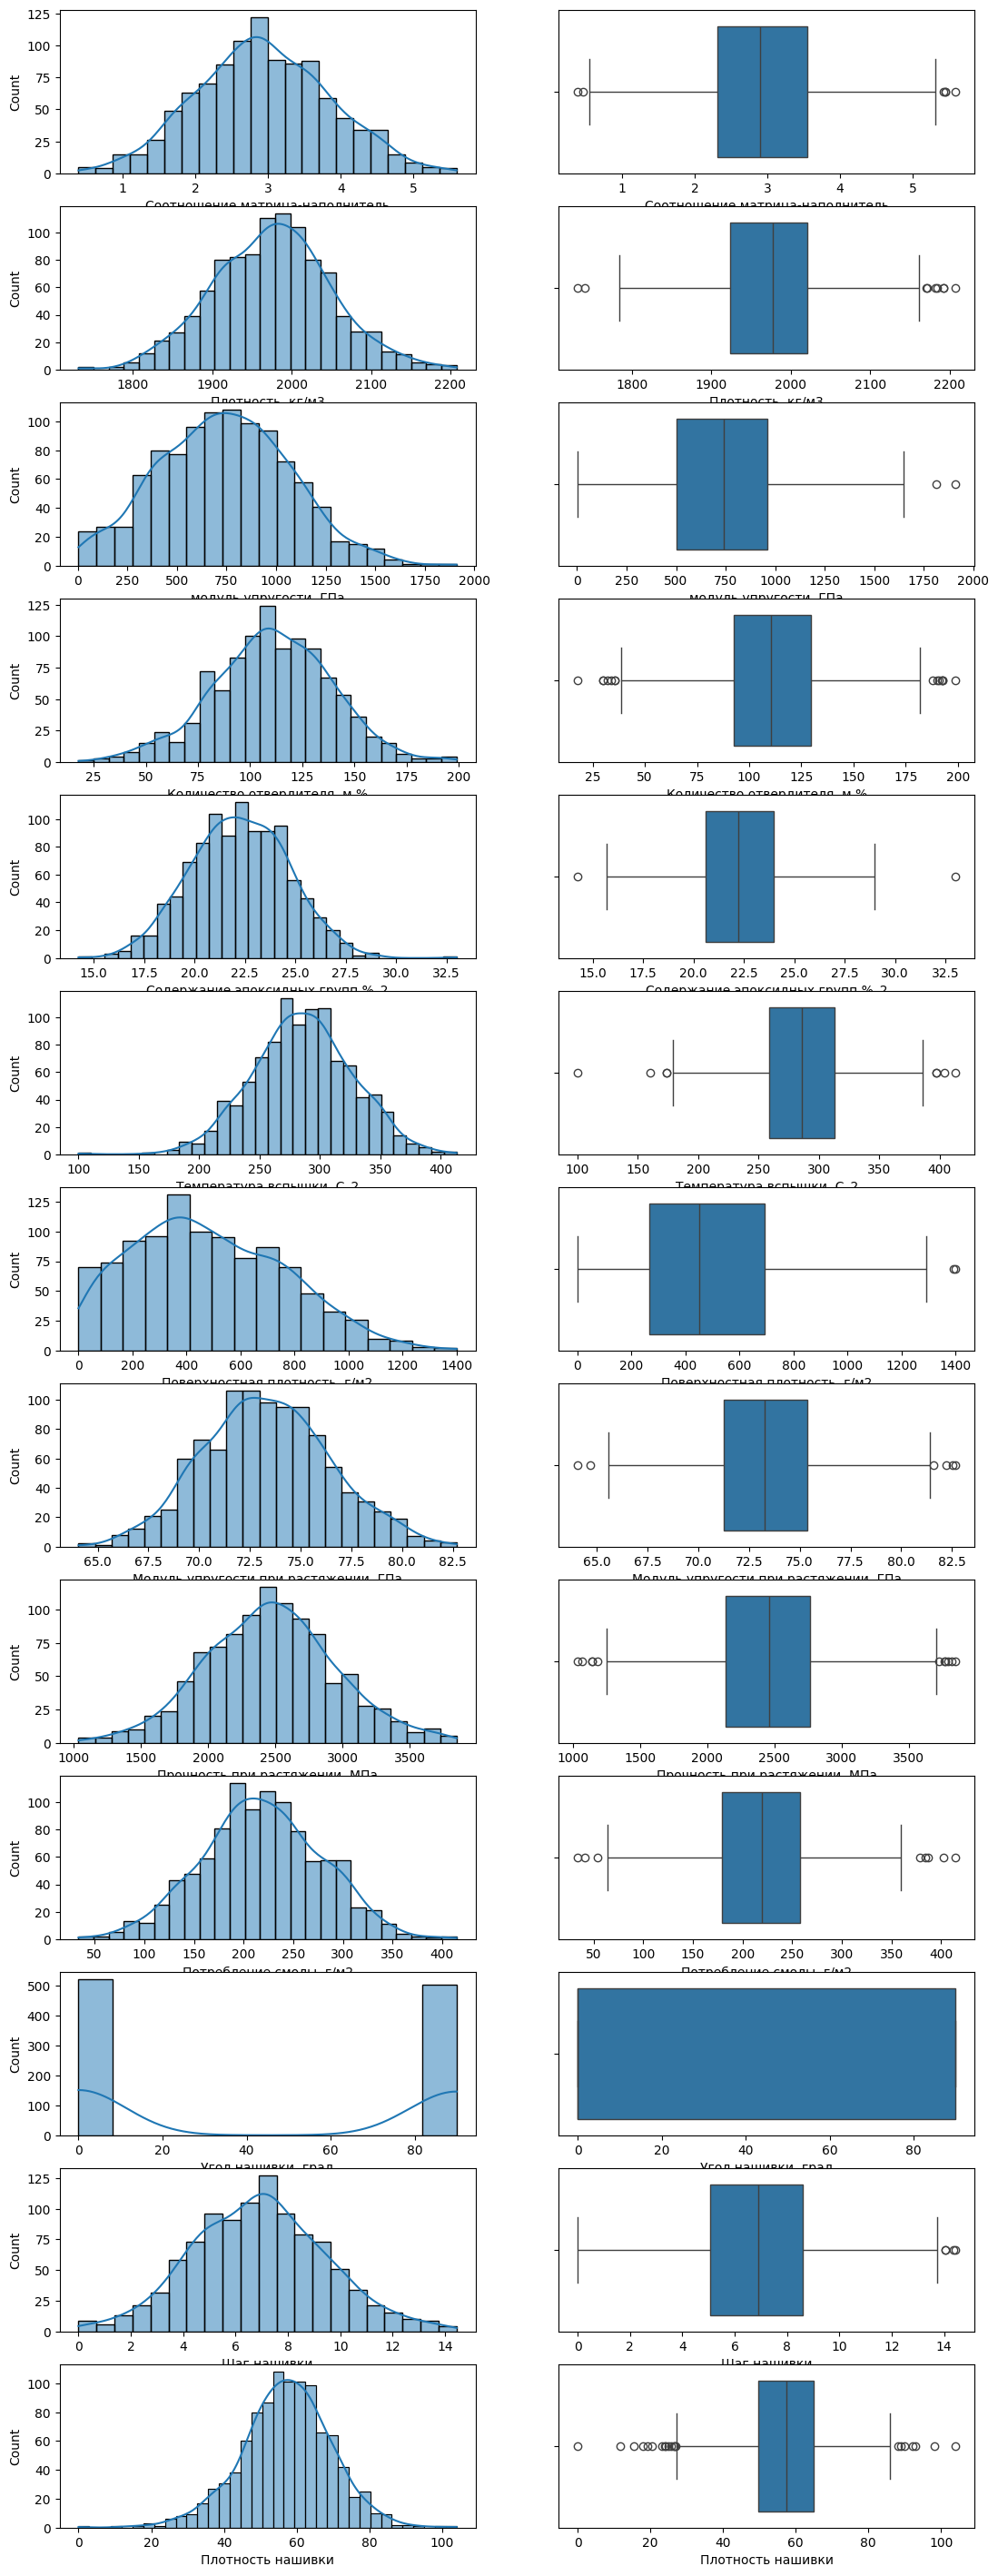

In [23]:
# Построение гиcтограмм признаков и  "ящиков с усами"
fig, axes = plt.subplots(13, 2, figsize=(13, 36))
for i, column in enumerate(X.columns):
    sns.histplot(data=X, x=column, kde=True, ax=axes[i, 0])
    sns.boxplot(data=X, x=column, ax=axes[i, 1])
plt.show()

! Все признаки, кроме "Угол нашивки, град" имеют нормальное распределение.
"Угол нашивки, град" принимает 2 значения.

In [24]:
# Построение попарных графиков рассеяния
sns.pairplot(X, height=2);

Output hidden; open in https://colab.research.google.com to view.

Графики показывают отсутствие явных зависимостей между признаками

### Корреляция

Рассмотрим корреляционную матрицу: (чем ближе коэффициенты к 1, тем большая зависимость наблюдается у признаков, если коэффициент положительный, то зависимость прямая, иначе обратная). Посмотрим также на соответствующую тепловую карту.

In [25]:
X.corr()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
Соотношение матрица-наполнитель,1.000,0.004,0.032,-0.006,0.020,-0.005,-0.006,-0.008,0.024,0.073,-0.031,0.036,-0.005
"Плотность, кг/м3",0.004,1.000,-0.010,-0.036,-0.008,-0.021,0.045,-0.018,-0.070,-0.016,-0.068,-0.061,0.080
"модуль упругости, ГПа",0.032,-0.010,1.000,0.024,-0.007,0.031,-0.005,0.023,0.042,0.002,-0.025,-0.010,0.056
"Количество отвердителя, м.%",-0.006,-0.036,0.024,1.000,-0.001,0.095,0.055,-0.066,-0.075,0.007,0.039,0.015,0.017
"Содержание эпоксидных групп,%_2",0.020,-0.008,-0.007,-0.001,1.000,-0.010,-0.013,0.057,-0.024,0.015,0.008,0.003,-0.039
"Температура вспышки, С_2",-0.005,-0.021,0.031,0.095,-0.010,1.000,0.020,0.028,-0.032,0.060,0.021,0.026,0.011
"Поверхностная плотность, г/м2",-0.006,0.045,-0.005,0.055,-0.013,0.020,1.000,0.037,-0.003,0.016,0.052,0.038,-0.050
"Модуль упругости при растяжении, ГПа",-0.008,-0.018,0.023,-0.066,0.057,0.028,0.037,1.000,-0.009,0.051,0.023,-0.029,0.006
"Прочность при растяжении, МПа",0.024,-0.070,0.042,-0.075,-0.024,-0.032,-0.003,-0.009,1.000,0.029,0.023,-0.060,0.020
"Потребление смолы, г/м2",0.073,-0.016,0.002,0.007,0.015,0.060,0.016,0.051,0.029,1.000,-0.015,0.013,0.012


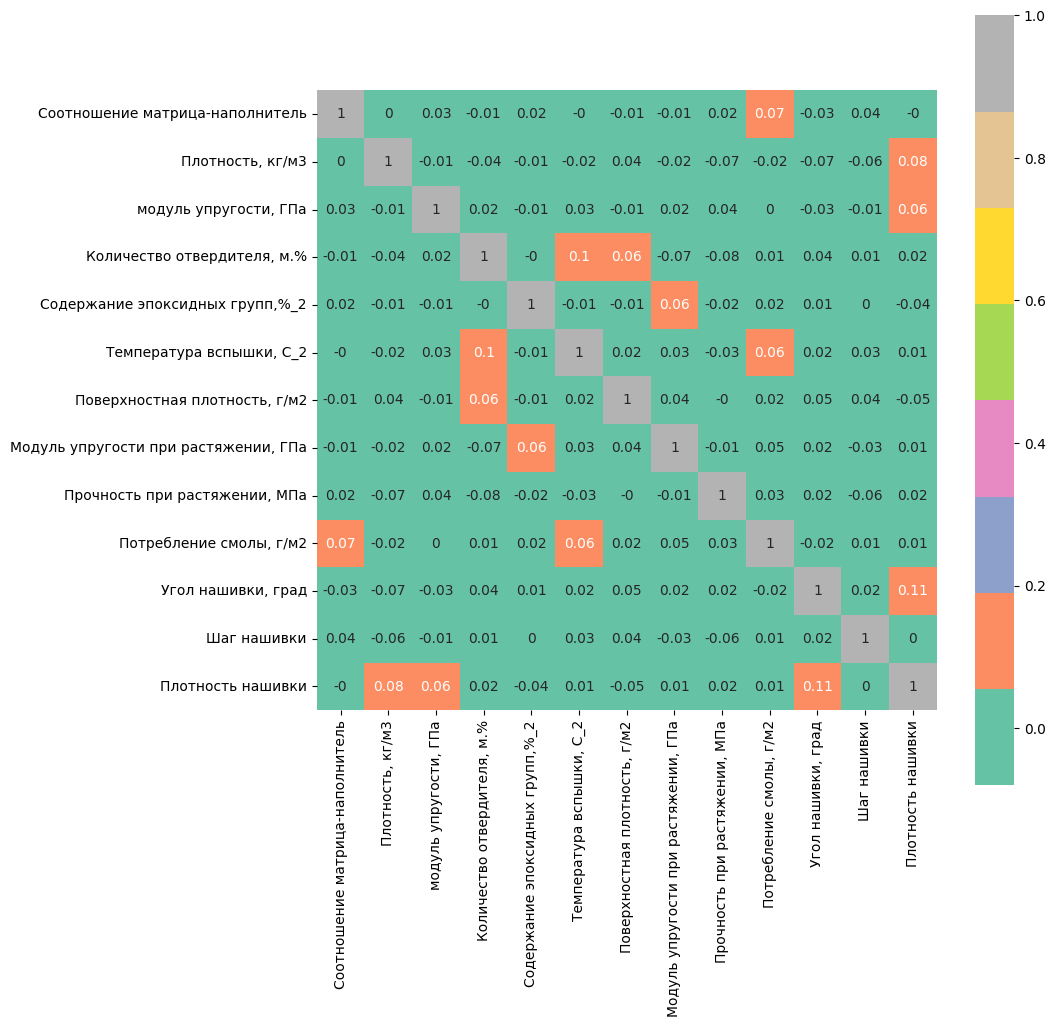

In [26]:
# Размер будущей тепловой карты. Можно указать в коде разово
plt.rcParams["figure.figsize"] = (10, 10)
sns.heatmap(
    data=X.corr().round(2),
    square=True,
    annot=True,cmap = 'Set2'
);

! Все полученные коэффициенты корреляции не превышают значения 0.11, что говорит о слабой попарной линейной  зависимости признаков

**Вспомогательные функции**

запуск моделей, кросс-валидацию и получение метрик в виде вспомогательной функции.

In [27]:
def run_models(models, x, y):
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=RANDOM_STATE)
    scoring = [ 'r2','neg_mean_squared_error','neg_root_mean_squared_error','neg_mean_absolute_error','max_error']
    for model_name, model in models.items():
        scores = cross_validate(model, x, y, cv=cv, scoring=scoring)
        stat.loc[model_name, 'R2'] = scores['test_r2'].mean()
        stat.loc[model_name, 'MSE'] = scores['test_neg_mean_squared_error'].mean() * -1
        stat.loc[model_name, 'RMSE'] = scores['test_neg_root_mean_squared_error'].mean() * -1
        stat.loc[model_name, 'MAE'] = scores['test_neg_mean_absolute_error'].mean() * -1
        stat.loc[model_name, 'max_error'] = scores['test_max_error'].mean() * -1
    return stat

Для поиска параметров по сетке тоже сделаю вспомогательную функцию, чтобы везде использовалась одинаковые параметры и одинаково выводился результат.

In [28]:
def run_grid_search(model, params, x, y):
    pd.options.display.max_colwidth = 200
    stat = pd.DataFrame()
    cv = KFold(10, shuffle=True, random_state=RANDOM_STATE)
    scoring = 'neg_root_mean_squared_error'
    searcher = GridSearchCV(model, params, cv=cv, scoring=scoring)
    searcher.fit(x, y)
    stat.loc[:, 'params'] = searcher.cv_results_['params']
    stat.loc[:, 'RMSE'] = searcher.cv_results_['mean_test_score']
    stat.loc[:, 'rank'] = searcher.cv_results_['rank_test_score']
    return stat, searcher.best_estimator_

функция для получения метрик предсказания

In [29]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'MSE'] = metrics.mean_squared_error(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred,squared = False)
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred)
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred)
    return stat

функция очистки методом методом межквартильных расстояний

In [30]:
def data_clr_guart(PAR):
    Z = PAR
    for column in Z.columns:
      q75,q25 = np.percentile(Z.loc[:,column],[75,25])
      intr_qr = q75 - q25
      max = q75+(1.5*intr_qr)
      min = q25-(1.5*intr_qr)
      Z.loc[Z[column] < min,column] = np.nan
      Z.loc[Z[column] > max,column] = np.nan
    return Z

### Подготовка данных

Поскольку данные не имеют пропуском и явных выбросов для исследования подготовим три массива: X1 - без предобработки, X2 - методом межквартильных расстояний, X3 - оставляем информативные признаки и обработка методом межквартильных расстояний

In [31]:
X1 = X
X2 = X
X3 = X.drop(['Соотношение матрица-наполнитель','Плотность, кг/м3','модуль упругости, ГПа','Температура вспышки, С_2','Угол нашивки, град', 'Плотность нашивки'], axis = 1)

Обработка X1

In [32]:
X1.isnull().sum()

,0
Соотношение матрица-наполнитель,0
"Плотность, кг/м3",0
"модуль упругости, ГПа",0
"Количество отвердителя, м.%",0
"Содержание эпоксидных групп,%_2",0
"Температура вспышки, С_2",0
"Поверхностная плотность, г/м2",0
"Модуль упругости при растяжении, ГПа",0
"Прочность при растяжении, МПа",0
"Потребление смолы, г/м2",0


In [33]:
X1_used = X1.dropna(axis = 0)
# Определение размера датасета после удаления выбросов и проверка наличия пропусков
print("Размер датасета после удаления выбросов и проверка наличия пропусков: \n",
      "\nКоличество строк в очищенном датасете: ", X1_used.shape[0],
      "\nКоличество столбцов (переменных) в очищенном датасете: ", X1_used.shape[1],
      "\nКоличество пропусков в данных очищенного датасета: ", X1_used.isna().sum().sum())

Размер датасета после удаления выбросов и проверка наличия пропусков: 
 
Количество строк в очищенном датасете:  1023 
Количество столбцов (переменных) в очищенном датасете:  13 
Количество пропусков в данных очищенного датасета:  0


Обработка X2

In [34]:
data_clr_guart(X2) #  очистка

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,1.857,2030.000,738.737,NaN,22.268,NaN,210.000,70.000,3000.000,220.000,0.000,4.000,57.000
1,1.857,2030.000,738.737,50.000,23.750,284.615,210.000,70.000,3000.000,220.000,0.000,4.000,60.000
2,1.857,2030.000,738.737,49.900,NaN,284.615,210.000,70.000,3000.000,220.000,0.000,4.000,70.000
3,1.857,2030.000,738.737,129.000,21.250,300.000,210.000,70.000,3000.000,220.000,0.000,5.000,47.000
4,2.771,2030.000,753.000,111.860,22.268,284.615,210.000,70.000,3000.000,220.000,0.000,5.000,57.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2.271,1952.088,912.856,86.992,20.123,324.775,209.199,73.091,2387.292,125.008,90.000,9.076,47.020
1019,3.444,2050.089,444.733,145.982,19.600,254.215,350.661,72.921,2360.393,117.730,90.000,10.566,53.751
1020,3.281,1972.373,416.837,110.533,23.958,248.423,740.143,74.734,2662.906,236.607,90.000,4.161,67.630
1021,3.705,2066.800,741.476,141.398,19.247,275.780,641.468,74.043,2071.716,197.126,90.000,6.313,58.261


In [35]:
X2.isnull().sum()

,0
Соотношение матрица-наполнитель,6
"Плотность, кг/м3",9
"модуль упругости, ГПа",2
"Количество отвердителя, м.%",14
"Содержание эпоксидных групп,%_2",2
"Температура вспышки, С_2",8
"Поверхностная плотность, г/м2",2
"Модуль упругости при растяжении, ГПа",6
"Прочность при растяжении, МПа",11
"Потребление смолы, г/м2",8


In [36]:
#удалим выбросы
X2_used = X2.dropna(axis = 0)

# Определение размера датасета после удаления выбросов и проверка наличия пропусков
print("Размер датасета после удаления выбросов и проверка наличия пропусков: \n",
      "\nКоличество строк в очищенном датасете: ", X2_used.shape[0],
      "\nКоличество столбцов (переменных) в очищенном датасете: ", X2_used.shape[1],
      "\nКоличество пропусков в данных очищенного датасета: ", X2_used.isna().sum().sum())

Размер датасета после удаления выбросов и проверка наличия пропусков: 
 
Количество строк в очищенном датасете:  936 
Количество столбцов (переменных) в очищенном датасете:  13 
Количество пропусков в данных очищенного датасета:  0


Обработка X3

In [37]:
data_clr_guart(X3) #  очистка

,"Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2",Шаг нашивки
0,NaN,22.268,210.000,70.000,3000.000,220.000,4.000
1,50.000,23.750,210.000,70.000,3000.000,220.000,4.000
2,49.900,NaN,210.000,70.000,3000.000,220.000,4.000
3,129.000,21.250,210.000,70.000,3000.000,220.000,5.000
4,111.860,22.268,210.000,70.000,3000.000,220.000,5.000
...,...,...,...,...,...,...,...
1018,86.992,20.123,209.199,73.091,2387.292,125.008,9.076
1019,145.982,19.600,350.661,72.921,2360.393,117.730,10.566
1020,110.533,23.958,740.143,74.734,2662.906,236.607,4.161
1021,141.398,19.247,641.468,74.043,2071.716,197.126,6.313


In [38]:
X3.isnull().sum()

,0
"Количество отвердителя, м.%",14
"Содержание эпоксидных групп,%_2",2
"Поверхностная плотность, г/м2",2
"Модуль упругости при растяжении, ГПа",6
"Прочность при растяжении, МПа",11
"Потребление смолы, г/м2",8
Шаг нашивки,4


In [39]:
#удалим выбросы
X3_used = X3.dropna(axis = 0)

# Определение размера датасета после удаления выбросов и проверка наличия пропусков
print("Размер датасета после удаления выбросов и проверка наличия пропусков: \n",
      "\nКоличество строк в очищенном датасете: ", X3_used.shape[0],
      "\nКоличество столбцов (переменных) в очищенном датасете: ", X3_used.shape[1],
      "\nКоличество пропусков в данных очищенного датасета: ", X3_used.isna().sum().sum())

Размер датасета после удаления выбросов и проверка наличия пропусков: 
 
Количество строк в очищенном датасете:  978 
Количество столбцов (переменных) в очищенном датасете:  7 
Количество пропусков в данных очищенного датасета:  0


## Алгоритмы машинного обучения
---



## Модель для прогноза модуля упругости при растяжении

Выделим из датасета прогнозируемую (зависимую) переменную. И разделим выборку на обучающую и тестовую выборки, в соответствии с условием задачи 70% (на обучение) /30% (на тестирование)

In [40]:
X1 = X1_used.drop('Модуль упругости при растяжении, ГПа', axis=1)
y1 = X1_used['Модуль упругости при растяжении, ГПа']
X2 = X2_used.drop('Модуль упругости при растяжении, ГПа', axis=1)
y2 = X2_used['Модуль упругости при растяжении, ГПа']
X3 = X3_used.drop('Модуль упругости при растяжении, ГПа', axis=1)
y3 = X3_used['Модуль упругости при растяжении, ГПа']

In [41]:
y1_used = np.array(y1) #преобразуем к массиву
y2_used = np.array(y2)
y3_used = np.array(y3)

Проведем маштабирование

In [42]:
#нормализуем входные данные с учетом возможности сохранения нормализатора
model_sc1 = MinMaxScaler().fit(X1)
model_sc2 = MinMaxScaler().fit(X2)
model_sc3 = MinMaxScaler().fit(X3)

X1_used_norm = model_sc1.transform(X1)
X2_used_norm = model_sc2.transform(X2)
X3_used_norm = model_sc3.transform(X3)


Для 1-го набора данных

In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_used_norm, y1_used, test_size=0.3, random_state=1)

In [44]:
print(f'Размер обучающей выборки: {X1_train.shape[0]}')
print(f'Размер тестовой выборки: {X1_test.shape[0]}')

Размер обучающей выборки: 716
Размер тестовой выборки: 307


Для 2-го набора данных

In [45]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_used_norm, y2_used, test_size=0.3, random_state=1)

In [46]:
print(f'Размер обучающей выборки: {X2_train.shape[0]}')
print(f'Размер тестовой выборки: {X2_test.shape[0]}')

Размер обучающей выборки: 655
Размер тестовой выборки: 281


Для 3-го набора данных

In [47]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_used_norm, y3_used, test_size=0.3, random_state=1)

In [48]:
print(f'Размер обучающей выборки: {X3_train.shape[0]}')
print(f'Размер тестовой выборки: {X3_test.shape[0]}')

Размер обучающей выборки: 684
Размер тестовой выборки: 294


### Модели регрессии с параметрами по умолчанию

In [49]:
# Сравнение моделей с параметрами по умолчанию
def_models1 = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(random_state=RANDOM_STATE)
}

In [50]:
stat1_1 = run_models(def_models1, X1_train, y1_train)
stat1_1.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.020216,9.533489,3.080099,2.474317,7.974898
LinearRegression,-0.034222,9.670851,3.101443,2.486065,7.970716
Lasso,-0.020216,9.533489,3.080099,2.474317,7.974898
SVR,-0.058617,9.896256,3.137457,2.540935,7.892049
RandomForestRegressor,-0.090505,10.169722,3.181979,2.544302,8.307188


In [51]:
stat1_1 # для отображения с 3 знаками для отчета

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.020,9.533,3.080,2.474,7.975
LinearRegression,-0.034,9.671,3.101,2.486,7.971
Lasso,-0.020,9.533,3.080,2.474,7.975
SVR,-0.059,9.896,3.137,2.541,7.892
RandomForestRegressor,-0.091,10.170,3.182,2.544,8.307


In [52]:
stat1_2 = run_models(def_models1, X2_train, y2_train)
stat1_2.style.highlight_min(axis=0)
#stat1_2

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.016296,9.177289,3.026052,2.419564,7.260095
LinearRegression,-0.042627,9.403422,3.063664,2.445329,7.577713
Lasso,-0.016296,9.177289,3.026052,2.419564,7.260095
SVR,-0.039109,9.382329,3.058296,2.448103,7.428522
RandomForestRegressor,-0.060685,9.577255,3.089440,2.466256,7.753488


In [53]:
stat1_3 = run_models(def_models1, X3_train, y3_train)
stat1_3.style.highlight_min(axis=0)
#stat1_3

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.015544,9.393654,3.046057,2.450878,7.208339
LinearRegression,-0.014587,9.321066,3.037800,2.447239,7.479776
Lasso,-0.015544,9.393654,3.046057,2.450878,7.208339
SVR,-0.070907,9.778540,3.113546,2.490891,7.568360
RandomForestRegressor,-0.090248,9.955545,3.142396,2.521497,7.845622


Ни одна из выбранных мной моделей не оказалась подходящей  для наших данных.

Коэффициент детерминации R2 близок к 0 для линейных моделей и метода Lasso.опорных векторов. Значит, они не лучше базовой модели. И остальные метрики у них примерно совпадают с базовой моделью.

Гораздо хуже линейных .с гиперпараметрами по умолчанию отработали метод опорных векторов и случайный лес.

### Модели регрессии с подбором параметров

In [54]:
# поиск параметров для моделей
s_models1 = {}

In [ ]:
# параметры для модели Lasso
#
# alpha, default=1.0

In [55]:
params1 = [
  {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.150, 0.2, 0.5, 0.8, 1]
  }
]
search, smodel = run_grid_search(Lasso(), params1, X2_train, y2_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
4,{'alpha': 0.1},-3.026,1
5,{'alpha': 0.15},-3.026,1
6,{'alpha': 0.2},-3.026,1
7,{'alpha': 0.5},-3.026,1
8,{'alpha': 0.8},-3.026,1
9,{'alpha': 1},-3.026,1


In [ ]:
# параметры для модели SVR
#
# kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
#
# Остальные параметры подходят для разных ядер
#
# C, default=1.0
# Regularization parameter

In [56]:
params1 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.01, 0.1, 0.5, 1, 5]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.1, 0.5, 1, 5]
    },
    {
      'kernel': ['rbf'],
      'C': [0.001, 0.5, 1, 5]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.001, 0.5, 1, 5]
    }
]
search, smodel = run_grid_search(SVR(), params1, X2_train, y2_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
19,"{'C': 5, 'kernel': 'sigmoid'}",-3.022,1


In [57]:
# параметры для RandomForestRegressor
#
# n_estimators
# The number of trees in the forest.
#
# criterion {“squared_error”, “absolute_error”, “poisson”}
# The function to measure the quality of a split
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split
#
# bootstrap
# Whether bootstrap samples are used when building trees

In [58]:
params1 = {
    'random_state': [RANDOM_STATE],
    'n_estimators': [50, 100],
    'criterion': ['squared_error','absolute_error'],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 3],
    'bootstrap': [False,True]
}
search, smodel = run_grid_search(RandomForestRegressor(), params1, X2_train, y2_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
85,"{'bootstrap': True, 'criterion': 'absolute_error', 'max_depth': 4, 'max_features': 1, 'n_estimators': 100, 'random_state': 42}",-3.021,1


In [59]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat1_2 = run_models(s_models1, X2_train, y2_train)
stat1_2.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
Lasso(alpha=0.1),-0.016296,9.177289,3.026052,2.419564,7.260095
"SVR(C=5, kernel='sigmoid')",-0.014557,9.152027,3.022427,2.413104,7.473540
"RandomForestRegressor(criterion='absolute_error', max_depth=4, max_features=1, random_state=42)",-0.012946,9.145340,3.020909,2.416233,7.361612


In [60]:
stat1_2

,R2,MSE,RMSE,MAE,max_error
Lasso(alpha=0.1),-0.016,9.177,3.026,2.420,7.260
"SVR(C=5, kernel='sigmoid')",-0.015,9.152,3.022,2.413,7.474
"RandomForestRegressor(criterion='absolute_error', max_depth=4, max_features=1,\n random_state=42)",-0.013,9.145,3.021,2.416,7.362


In [61]:
# Предсказание базовой модели
base_model1 = DummyRegressor(strategy='mean')
base_model1.fit(X2_train, y2_train)
y2_pred_base = base_model1.predict(X2_test)

In [62]:
# Предсказание лучшей модели
best_model1 = SVR( kernel='sigmoid',C = 5)
best_model1.fit(X2_train,y2_train)
y2_pred_best = best_model1.predict(X2_test)

In [63]:
get_metrics(base_model1, y2_test, y2_pred_base)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor(),-0.001,9.362,3.060,2.522,7.873


In [64]:
get_metrics(best_model1, y2_test, y2_pred_best)

,R2,MSE,RMSE,MAE,max_error
"SVR(C=5, kernel='sigmoid')",-0.042,9.746,3.122,2.558,9.327


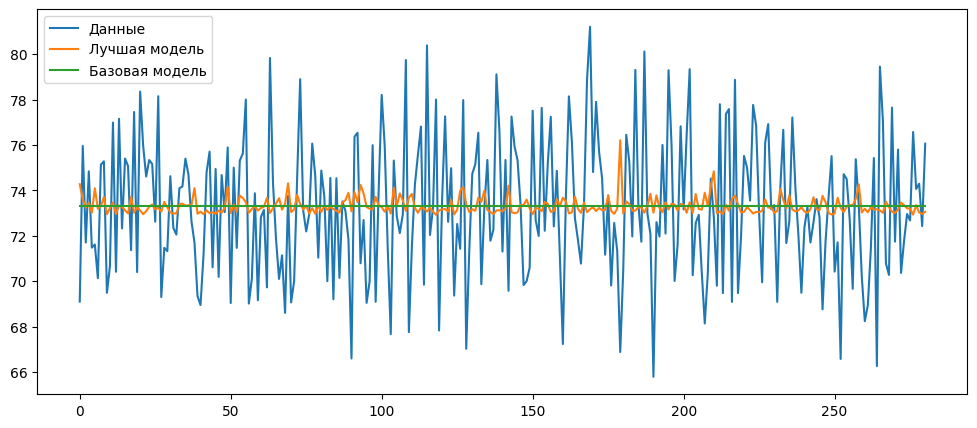

In [65]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y2_test, label='Данные')
ax.plot(y2_pred_best, label='Лучшая модель')
ax.plot(y2_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [66]:
#для проверки работоспособности при записи и считывания модели в конце программы
X2_ = X2

## Модель для прогноза прочности при растяжении

Выделим из датасета прогнозируемую (зависимую) переменную. И разделим выборку на обучающую и тестовую выборки, в соответствии с условием задачи 70% (на обучение) /30% (на тестирование)

In [67]:
X1 = X1_used.drop('Прочность при растяжении, МПа', axis=1)
y1 = X1_used['Прочность при растяжении, МПа']
X2 = X2_used.drop('Прочность при растяжении, МПа', axis=1)
y2 = X2_used['Прочность при растяжении, МПа']
X3 = X3_used.drop('Прочность при растяжении, МПа', axis=1)
y3 = X3_used['Прочность при растяжении, МПа']

In [68]:
y1_used = np.array(y1) #преобразуем к массиву
y2_used = np.array(y2)
y3_used = np.array(y3)

In [69]:
#нормализуем входные данные с учетом возможности сохранения нормализатора

model_sc1_2 = MinMaxScaler().fit(X1)
model_sc2_2 = MinMaxScaler().fit(X2)
model_sc3_2 = MinMaxScaler().fit(X3)

X1_used_norm = model_sc1_2.transform(X1)
X2_used_norm = model_sc2_2.transform(X2)
X3_used_norm = model_sc3_2.transform(X3)

Для 1-го набора данных

In [70]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_used_norm, y1_used, test_size=0.3, random_state=1)

In [71]:
print(f'Размер обучающей выборки: {X1_train.shape[0]}')
print(f'Размер тестовой выборки: {X1_test.shape[0]}')

Размер обучающей выборки: 716
Размер тестовой выборки: 307


Для 2-го набора данных

In [72]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_used_norm, y2_used, test_size=0.3, random_state=1)

In [73]:
print(f'Размер обучающей выборки: {X2_train.shape[0]}')
print(f'Размер тестовой выборки: {X2_test.shape[0]}')

Размер обучающей выборки: 655
Размер тестовой выборки: 281


Для 3-го набора данных

In [74]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_used_norm, y3_used, test_size=0.3, random_state=1)

In [75]:
print(f'Размер обучающей выборки: {X3_train.shape[0]}')
print(f'Размер тестовой выборки: {X3_test.shape[0]}')

Размер обучающей выборки: 684
Размер тестовой выборки: 294


### Модели регрессии с параметрами по умолчанию

In [76]:
# Сравнение моделей с параметрами по умолчанию
def_models1 = {
    'DummyRegressor': DummyRegressor(strategy='mean'),
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'RandomForestRegressor': RandomForestRegressor(random_state=RANDOM_STATE)
}

In [77]:
stat1_1 = run_models(def_models1, X1_train, y1_train)
stat1_1.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.005263,219988.081944,466.070179,366.786552,1180.419658
LinearRegression,-0.027748,224429.643499,470.897585,371.613630,1205.611119
Lasso,-0.017708,222509.090379,468.784265,369.669315,1195.738223
SVR,-0.004052,219749.473356,465.802047,366.655942,1179.055346
RandomForestRegressor,-0.076558,233729.240424,480.977083,382.232164,1189.369367


In [78]:
stat1_1

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.005,219988.082,466.070,366.787,1180.420
LinearRegression,-0.028,224429.643,470.898,371.614,1205.611
Lasso,-0.018,222509.090,468.784,369.669,1195.738
SVR,-0.004,219749.473,465.802,366.656,1179.055
RandomForestRegressor,-0.077,233729.240,480.977,382.232,1189.369


In [79]:
stat1_2 = run_models(def_models1, X2_train, y2_train)
stat1_2.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.030152,218763.434130,466.269207,370.786993,1125.425077
LinearRegression,-0.058030,223584.571167,471.641622,376.792249,1121.774403
Lasso,-0.050047,222075.214194,470.021585,374.775484,1121.612436
SVR,-0.027441,218386.232536,465.779831,370.109923,1124.889637
RandomForestRegressor,-0.069466,225156.918892,473.432723,377.218718,1106.807045


In [80]:
stat1_2

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.030,218763.434,466.269,370.787,1125.425
LinearRegression,-0.058,223584.571,471.642,376.792,1121.774
Lasso,-0.050,222075.214,470.022,374.775,1121.612
SVR,-0.027,218386.233,465.780,370.110,1124.890
RandomForestRegressor,-0.069,225156.919,473.433,377.219,1106.807


In [81]:
stat1_3 = run_models(def_models1, X3_train, y3_train)
stat1_3.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.020251,204144.861142,450.983622,360.168617,1144.608073
LinearRegression,-0.022366,204439.568453,451.356209,360.134224,1156.106202
Lasso,-0.019784,203966.347194,450.816301,359.889330,1155.016086
SVR,-0.018833,203832.816679,450.657030,359.917623,1143.235604
RandomForestRegressor,-0.060563,212156.741162,459.558483,371.274291,1200.850223


In [82]:
stat1_3

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.020,204144.861,450.984,360.169,1144.608
LinearRegression,-0.022,204439.568,451.356,360.134,1156.106
Lasso,-0.020,203966.347,450.816,359.889,1155.016
SVR,-0.019,203832.817,450.657,359.918,1143.236
RandomForestRegressor,-0.061,212156.741,459.558,371.274,1200.850


Ни одна из выбранных мной моделей не оказалась подходящей  для наших данных.

Коэффициент детерминации R2 близок к 0 для модели Lasso и метода опорных векторов.

Гораздо хуже линейных с  отработал метод cлучайного леса .

In [83]:
# поиск параметров для моделей
s_models1 = {}

In [84]:
# параметры для модели Lasso
#
# alpha, default=1.0
# Constant that multiplies the L1 term.

In [85]:
params1 = [
  {
    'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.150, 0.2, 0.5, 0.8, 1]
  }
]
search, smodel = run_grid_search(Lasso(), params1, X3_train, y3_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
9,{'alpha': 1},-450.816,1


In [ ]:
# параметры для модели SVR
#
# kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
#
# Остальные параметры подходят для разных ядер
#
# C, default=1.0
# Regularization parameter

In [86]:
params1 = [
    {
      'kernel': ['linear'],
      'C': [0.001, 0.01, 0.1, 0.5, 1, 5]
    },
    {
      'kernel': ['poly'],
      'C': [0.001, 0.01, 0.1, 0.5, 1, 5]
    },
    {
      'kernel': ['rbf'],
      'C': [0.001, 0.5, 1, 5]
    },
    {
      'kernel': ['sigmoid'],
      'C': [0.001, 0.5, 1, 5]
    }
]
search, smodel = run_grid_search(SVR(), params1, X3_train, y3_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
7,"{'C': 0.01, 'kernel': 'poly'}",-450.509,1


In [ ]:
# параметры для RandomForestRegressor
#
# n_estimators
# The number of trees in the forest.
#
# criterion {“squared_error”, “absolute_error”, “poisson”}
# The function to measure the quality of a split
#
# max_depth
# The maximum depth of the tree
#
# max_features
# The number of features to consider when looking for the best split
#
# bootstrap
# Whether bootstrap samples are used when building trees

In [87]:
params1 = {
    'random_state': [RANDOM_STATE],
    'n_estimators': [50, 100],
    'criterion': ['squared_error','absolute_error'],
    'max_depth': [2, 3, 4, 5],
    'max_features': [1, 2, 3],
    'bootstrap': [False,True]
}
search, smodel = run_grid_search(RandomForestRegressor(), params1, X3_train, y3_train)
s_models1[str(smodel)] = smodel
search[search['rank']==1]

,params,RMSE,rank
30,"{'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 3, 'max_features': 1, 'n_estimators': 50, 'random_state': 42}",-446.463,1


In [88]:
# Сравнение моделей с подобранными параметрами, поиск лучшей
stat1_2 = run_models(s_models1, X3_train, y3_train)
stat1_2.style.highlight_min(axis=0)

,R2,MSE,RMSE,MAE,max_error
Lasso(alpha=1),-0.019784,203966.347194,450.816301,359.889330,1155.016086
"SVR(C=0.01, kernel='poly')",-0.018193,203692.791237,450.508686,359.799586,1143.599458
"RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=3, max_features=1, n_estimators=50, random_state=42)",0.000358,200148.869993,446.463366,356.324487,1142.808913


In [89]:
stat1_2

,R2,MSE,RMSE,MAE,max_error
Lasso(alpha=1),-0.020,203966.347,450.816,359.889,1155.016
"SVR(C=0.01, kernel='poly')",-0.018,203692.791,450.509,359.800,1143.599
"RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=3,\n max_features=1, n_estimators=50, random_state=42)",0.000,200148.870,446.463,356.324,1142.809


In [90]:
# Предсказание базовой модели
base_model2 = DummyRegressor(strategy='mean')
base_model2.fit(X3_train, y3_train)
y3_pred_base = base_model2.predict(X3_test)

In [91]:
# Предсказание лучшей модели
best_model2 = RandomForestRegressor(n_estimators = 50, bootstrap=False, criterion='absolute_error', max_depth=3, max_features=1, random_state=42)
best_model2.fit(X3_train, y3_train)
y3_pred_best = best_model2.predict(X3_test)

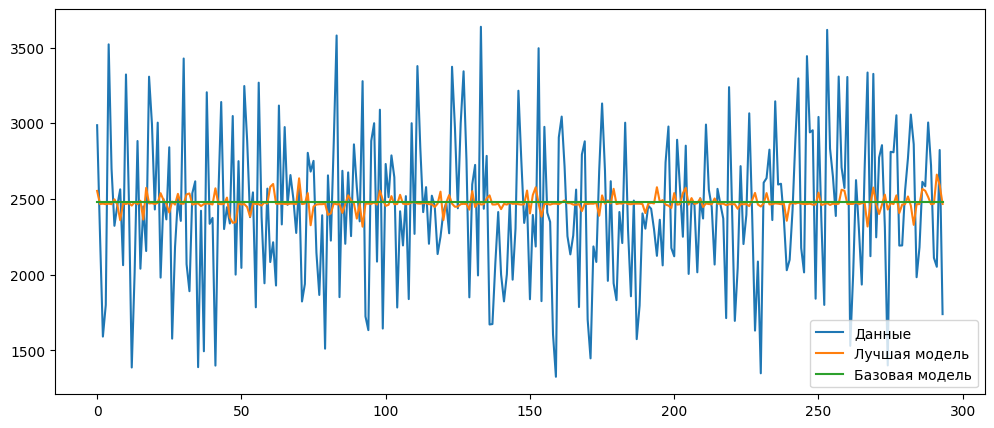

In [92]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(y3_test, label='Данные')
ax.plot(y3_pred_best, label='Лучшая модель')
ax.plot(y3_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [93]:
get_metrics(base_model2, y3_test, y3_pred_base)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor(),-0.006,237638.567,487.482,389.470,1159.880


In [94]:
get_metrics('RandomForestRegressor', y3_test, y3_pred_best)

,R2,MSE,RMSE,MAE,max_error
RandomForestRegressor,-0.022,241364.991,491.289,391.276,1173.770


# Нейросеть для рекомендации соотношения матрица-наполнитель

### Модель для соотношения матрица-наполнитель

In [95]:
# константы для НС
UNIT = 72
UNIT1 = 12
MAX_ITER = 5000
EPOCH = 30

In [96]:
X4 = X1_used.drop('Соотношение матрица-наполнитель', axis=1)
y4 = X1_used['Соотношение матрица-наполнитель']

In [97]:
y4_used = np.array(y4) #преобразуем к массиву

In [99]:
# нормализация
model_sc4 = MinMaxScaler().fit(X4)
X4_used_norm = model_sc4.transform(X4)


In [100]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4_used_norm, y4_used, test_size=0.3, random_state=1)

In [101]:
print(f'Размер обучающей выборки: {X4_train.shape}')
print(f'Размер тестовой выборки: {X4_test.shape}')

Размер обучающей выборки: (716, 12)
Размер тестовой выборки: (307, 12)


In [102]:
# Описательная статистика входных данных после предобработки
pd.DataFrame(X4_train).describe().T

,count,mean,std,min,25%,50%,75%,max
0,716.000,0.517,0.159,0.000,0.403,0.519,0.617,1.000
1,716.000,0.390,0.173,0.000,0.270,0.388,0.497,1.000
2,716.000,0.511,0.155,0.000,0.413,0.513,0.617,1.000
3,716.000,0.426,0.126,0.077,0.341,0.427,0.518,0.782
4,716.000,0.594,0.127,0.000,0.513,0.594,0.679,1.000
5,716.000,0.356,0.201,0.004,0.201,0.343,0.501,0.923
6,716.000,0.505,0.166,0.000,0.393,0.502,0.615,1.000
7,716.000,0.507,0.167,0.012,0.399,0.507,0.610,0.989
8,716.000,0.488,0.156,0.000,0.384,0.487,0.594,1.000
9,716.000,0.496,0.500,0.000,0.000,0.000,1.000,1.000


По заданию для соотношения матрица-наполнитель необходимо построить нейросеть.

Но базовая модель DummyRegressor, возвращающая среднее, для оценки качества модели тоже понадобится.

In [103]:
# Базовая модель
base_model3 = DummyRegressor(strategy='mean')

In [104]:
# Предсказание базовой модели
base_model3.fit(X4_train, y4_train)

DummyRegressor()

In [105]:
y4_test_base = base_model3.predict(X4_test)

In [106]:
get_metrics(base_model3,y4_test,y4_test_base)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor(),-0.000,0.861,0.928,0.743,2.539


Модель MLPRegressor из библиотеки sklearn.

In [107]:
# Настройка нейросети
model3_1 = MLPRegressor(
    hidden_layer_sizes = (UNIT,UNIT, UNIT, UNIT, UNIT, UNIT, UNIT, UNIT),
    activation = 'relu',
    solver='adam',
    max_iter=MAX_ITER,
    early_stopping = True,
    validation_fraction = 0.3,
    random_state=RANDOM_STATE,
    verbose=True
)

In [108]:
%%time
# Запуск нейросети
model3_1.fit(X4_train, y4_train)

Iteration 1, loss = 5.10747071
Validation score: -9.836480
Iteration 2, loss = 4.44553742
Validation score: -8.218482
Iteration 3, loss = 3.72184633
Validation score: -6.415874
Iteration 4, loss = 2.87757430
Validation score: -4.092938
Iteration 5, loss = 1.79579315
Validation score: -1.418583
Iteration 6, loss = 0.72790312
Validation score: -0.040611
Iteration 7, loss = 0.58027682
Validation score: -1.058422
Iteration 8, loss = 0.87585877
Validation score: -0.269143
Iteration 9, loss = 0.48748957
Validation score: -0.047694
Iteration 10, loss = 0.43103702
Validation score: -0.334924
Iteration 11, loss = 0.52776079
Validation score: -0.411932
Iteration 12, loss = 0.52719883
Validation score: -0.231949
Iteration 13, loss = 0.44571781
Validation score: -0.040543
Iteration 14, loss = 0.40462203
Validation score: -0.019900
Iteration 15, loss = 0.42046829
Validation score: -0.054302
Iteration 16, loss = 0.43545854
Validation score: -0.023269
Iteration 17, loss = 0.41018896
Validation score:

MLPRegressor(early_stopping=True,
             hidden_layer_sizes=(72, 72, 72, 72, 72, 72, 72, 72), max_iter=5000,
             random_state=42, validation_fraction=0.3, verbose=True)

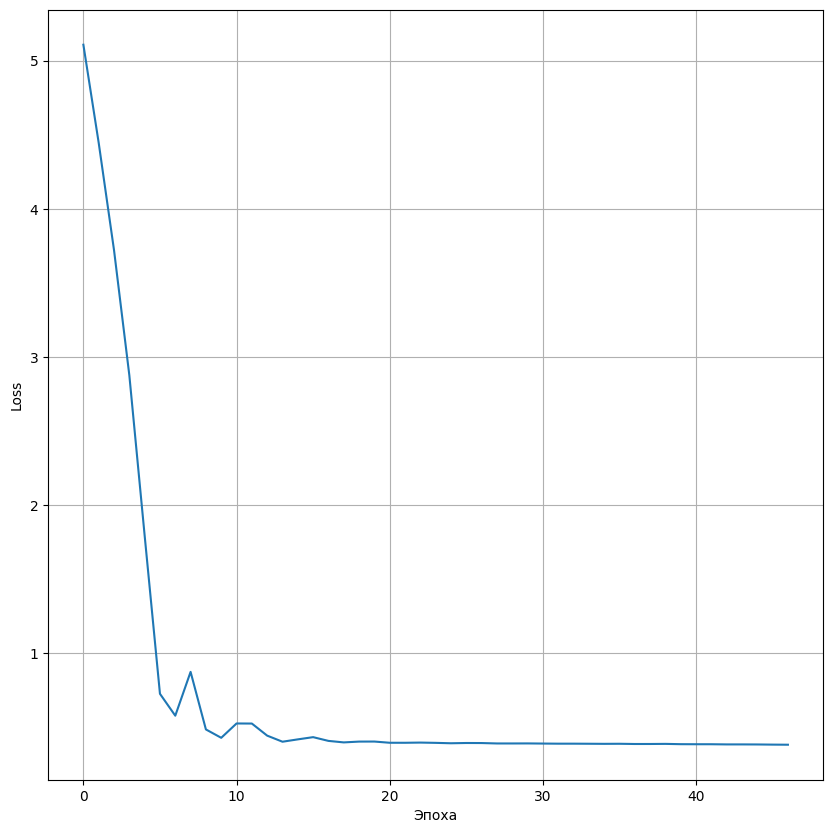

In [109]:
# График ошибки
plt.plot(model3_1.loss_curve_)
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [110]:
# Предсказание нейросети
y4_test_pred = model3_1.predict(X4_test)

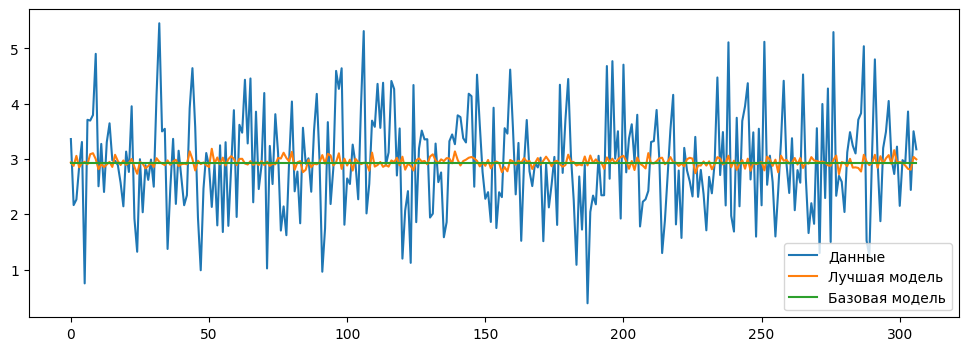

In [111]:
# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y4_test, label='Данные')
ax.plot(y4_test_pred, label='Лучшая модель')
ax.plot(y4_test_base, label='Базовая модель')
ax.legend()
plt.show()

In [112]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
get_metrics('DummyRegressor', y4_test, y4_test_base)

,R2,MSE,RMSE,MAE,max_error
DummyRegressor,-0.000,0.861,0.928,0.743,2.539


In [113]:
get_metrics('MLPRegressor', y4_test, y4_test_pred)

,R2,MSE,RMSE,MAE,max_error
MLPRegressor,0.003,0.858,0.926,0.743,2.506


Нейросеть, построенная с помощью MLPRegressor, возвращает данные, похожие на исходные. Но ошибка  по всем метрикам значительно хуже, чем у базовой модели. Возможно, ошибку можно уменьшить, экспериментируя со структурой нейросети.

In [114]:
#для проверки работоспособности при записи и считывания модели в конце программы
X1_ = X4 # тут я намудрил с нумерацией датасетов

In [115]:
# Построить нейронную сеть с помощью библиотеки TensorFlow.

In [116]:
# Функция, собирающая нейросеть заданной архитектуры
def construct_model():
    return tf.keras.Sequential([
      keras.layers.Input(shape=(12,), name='in'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_1'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_2'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_3'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_4'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_5'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_6'),
      keras.layers.Dense(units=UNIT1, activation='relu', name='dense_7'),
      keras.layers.Dense(units=4, activation='relu', name='dense_8'),
      keras.layers.Dense(units=1, name='out')
    ])

In [117]:
# Функция, компилирующая нейросеть с заданными параметрами
def compile_model(model):
    model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    return model


In [118]:
# Функция для построения графика ошибки
def plot_loss(history):
  fig, axes = plt.subplots(figsize=(12, 5))
  axes.plot(history['loss'], label='loss')
  axes.plot(history['val_loss'], label='val_loss')
  axes.set_xlabel('Эпоха')
  axes.set_ylabel('MSE')
  axes.legend(['обучающая','тестовая'])
  axes.grid(True)
  plt.show()

In [119]:
# Собираю нейросеть
model3_2 = construct_model()

In [120]:
# Компилирую нейросеть
model3_2 = compile_model(model3_2)

In [121]:
# Сводная информация по архитектуре сети
model3_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,149 (4.49 KB)

 Trainable params: 1,149 (4.49 KB)

 Non-trainable params: 0 (0.00 B)

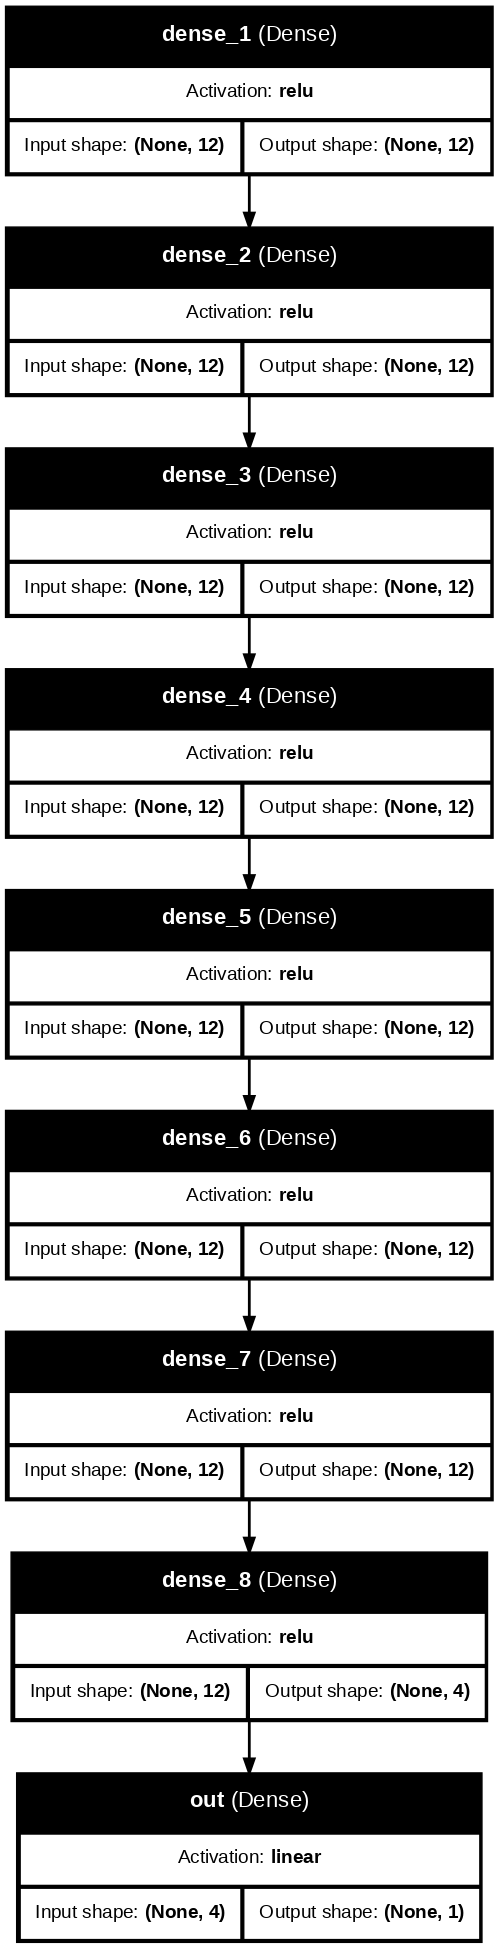

In [122]:
# Архитектура нейросети визуально
keras.utils.plot_model(model3_2, show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi =100)

In [123]:
%%time
#Обучение нейросети
history = model3_2.fit(
  X4_train,
  y4_train,
  epochs=EPOCH,
  validation_split=0.3,
  verbose=1
)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 8.1213 - mean_squared_error: 8.1213 - val_loss: 6.8690 - val_mean_squared_error: 6.8690
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6175 - mean_squared_error: 6.6175 - val_loss: 3.5713 - val_mean_squared_error: 3.5713
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8050 - mean_squared_error: 2.8050 - val_loss: 0.8895 - val_mean_squared_error: 0.8895
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0597 - mean_squared_error: 1.0597 - val_loss: 0.8812 - val_mean_squared_error: 0.8812
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9202 - mean_squared_error: 0.9202 - val_loss: 0.8490 - val_mean_squared_error: 0.8490
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8878 - mean_squared_error: 0.8878 - val_loss: 0.8660 - val_mean_squared_error: 0.8660
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8567 - mean_squared_error: 0.8567 - val_loss: 0.8417 - val_mean

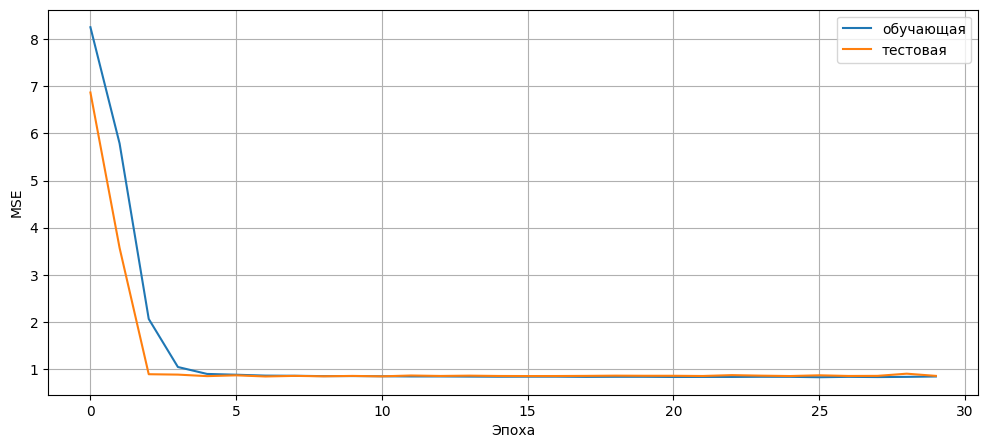

In [124]:
plot_loss(history.history)

In [126]:
# Проверяем точность нейросети на тестовых данных
model3_2.evaluate(X4_test, y4_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8686 - mean_squared_error: 0.8686 


[0.8857656717300415, 0.8857656717300415]

In [127]:
# Предсказание
y4_pred_keras2 = model3_2.predict(X4_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


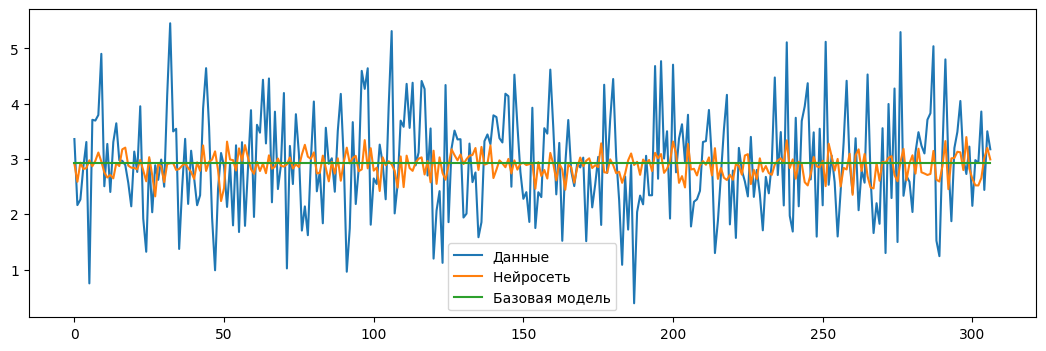

In [128]:
# Визуализация
fig, ax = plt.subplots(figsize=(13, 4))
ax.plot(y4_test, label='Данные')
ax.plot(y4_pred_keras2, label='Нейросеть ')
ax.plot(y4_test_base, label='Базовая модель')
ax.legend()
plt.show()

In [129]:
get_metrics('Keras', y4_test, y4_pred_keras2)

,R2,MSE,RMSE,MAE,max_error
Keras,-0.029,0.886,0.941,0.756,2.611


# Сохранение модели

Для использования в приложении обученных моделей их надо сохранить. Модели из библиотеки sklearn сохраняю с помощью pickle. Модели из библиотеки tensorflow имеют собственный механизм сохранения.

In [132]:
#создадим папку для моделей
#models_path='/content/sample_data/models/'
os.mkdir(models_path)
os.mkdir(models_path+'/model3_2/')

In [133]:
#функция  сохранения модели в файле
def save_object_with_pickle(obj, obj_name):
  filename = models_path + obj_name
  file = open(filename, 'wb')
  pickle.dump(obj, file)
  file.close()

In [134]:
#функция  загрузки модели из файла
def load_object_with_pickle(obj_name):
  filename = models_path + obj_name
  file = open(filename, 'rb')
  obj = pickle.load(file)
  file.close()
  return obj

In [135]:
save_object_with_pickle(model_sc2, 'model1_sc2')

In [136]:
save_object_with_pickle(best_model1, 'model1_best')

In [138]:
save_object_with_pickle(model_sc3_2, 'model2_sc3_2')

In [139]:
save_object_with_pickle(best_model2, 'model2_best')

In [140]:
save_object_with_pickle(model_sc4, 'model3_sc4')

In [141]:
save_object_with_pickle(model3_1, 'model3_1')

In [155]:
models_path_ker = models_path + '/model3_2/'+'model.keras'
model3_2.save(models_path_ker)

In [ ]:
# Проверяю загрузку

In [ ]:
model_sc2 = load_object_with_pickle('model1_sc2')
best_model1 = load_object_with_pickle('model1_best')
best_model1

SVR(C=5, kernel='sigmoid')

In [ ]:
model_sc3_2 = load_object_with_pickle('model2_sc3_2')
best_model2 = load_object_with_pickle('model2_best')
best_model2

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=3,
                      max_features=1, n_estimators=50, random_state=42)

In [ ]:
model_sc4 = load_object_with_pickle('model3_sc4')
model3_1 = load_object_with_pickle('model3_1')
model3_1

MLPRegressor(early_stopping=True,
             hidden_layer_sizes=(72, 72, 72, 72, 72, 72, 72, 72), max_iter=5000,
             random_state=42, validation_fraction=0.3, verbose=True)

In [ ]:
# Примеры для тестирования модели в приложении для задач 1 и 3

In [145]:
# 1-ая Модель SVR
# Вход датасет X2
X2_.iloc[7, :].values.astype(str)

array(['3.532338308', '2100.0', '1421.0', '129.0', '21.25', '300.0',
       '1010.0', '2000.0', '300.0', '0.0', '7.0', '60.0'], dtype='<U32')

In [146]:
sample_x = model_sc2.transform(X2_.iloc[[7], :])

In [147]:
# Выход

sample_x = model_sc2.transform(X2_.iloc[[11], :])
best_model1.predict(sample_x)

array([73.12416989])

In [148]:
# Примеры для тестирования модели в приложении для задачи 3

In [149]:
# Вход X1_
X1_.iloc[11, :].values.astype(str)

array(['1990.0', '1628.0', '129.0', '21.25', '300.0', '1010.0', '78.0',
       '2000.0', '300.0', '0.0', '9.0', '47.0'], dtype='<U32')

In [150]:
# Выход
sample_x = model_sc4.transform(X1_.iloc[[11], :])
model3_1.predict(sample_x)

array([3.13159514])

In [157]:
model_rest_keras = keras.models.load_model(models_path_ker)
model_rest_keras.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4)                   │              52 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ out (Dense)                          │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,449 (13.48 KB)

 Trainable params: 1,149 (4.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,300 (8.99 KB)